In [16]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [17]:
with open('./dataset/train_data.txt', 'r') as f:
    datas = f.read().split('\n')

In [18]:
data = datas[0]
data

'/VOC2007/JPEGImages/img_773.jpg 9,157,323,639,19 639,97,1016,583,19'

In [19]:
path = data.split()[0]
bboxs = data.split()[1:]
bboxs

['9,157,323,639,19', '639,97,1016,583,19']

In [5]:
bbox = bboxs[0]
bbox

'9,157,323,639,19'

In [6]:
box = list(map(int, bbox.split(',')))[:4]
label = list(map(int, bbox.split(',')))[4]
print(box)
print(label)

[9, 157, 323, 639]
19


In [7]:
labels = []
boxes = []
for bbox in bboxs:
    boxes.append(list(map(int, bbox.split(',')))[:4])
    labels.append(list(map(int, bbox.split(',')))[4])
print(labels)
np.array(boxes, dtype=np.float32)

[19, 19]


array([[   9.,  157.,  323.,  639.],
       [ 639.,   97., 1016.,  583.]], dtype=float32)

In [32]:
class WheatDataset(Dataset):

    def __init__(self, datas, transforms=None):
        super().__init__()

        # self.image_ids = dataframe['image_id'].unique()
        self.datas = datas
        # self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        # image_id = self.image_ids[index]
        # records = self.df[self.df['image_id'] == image_id]
        data = self.datas[index]
        path = data.split()[0]
        bboxs = data.split()[1:]

        image = cv2.imread("../trainval" + path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        labels = []
        boxes = []
        for bbox in bboxs:
            boxes.append(list(map(int, bbox.split(',')))[:4])
            labels.append(list(map(int, bbox.split(',')))[4])
            
        boxes = np.array(boxes, dtype=np.float32)
        labels = torch.from_numpy(np.array(labels, dtype=np.int64))

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
#         labels = torch.ones((records.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
#         iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
#         target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, path

    def __len__(self) -> int:
        return len(self.datas)



In [33]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.RandomRotate90(),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.RandomRotate90(),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [11]:

num_classes = 45  # 44 class  + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [12]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [36]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(datas, get_train_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [28]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


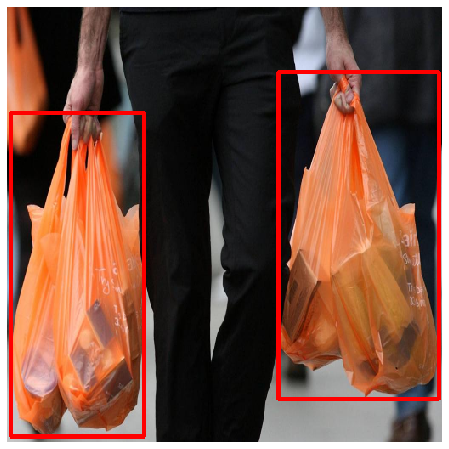

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [18]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [20]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

Process Process-9:
Process Process-11:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/util.py", line 325, in _exit_function
    _run_finalizers()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/util.py", line 325, in _exit_function
    _run_finalizers()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __

KeyboardInterrupt: 

In [37]:
for epoch in range(20):
#     loss_hist.reset()
    
    for images, targets, path in train_data_loader:
        print(path)

('/VOC2007/JPEGImages/img_773.jpg',)
('/VOC2007/JPEGImages/img_3184.jpg',)
('/VOC2007/JPEGImages/img_10962.jpg',)
('/VOC2007/JPEGImages/img_1793.jpg',)
('/VOC2007/JPEGImages/img_18480.jpg',)
('/VOC2007/JPEGImages/img_5293.jpg',)
('/VOC2007/JPEGImages/img_12813.jpg',)
('/VOC2007/JPEGImages/img_18494.jpg',)
('/VOC2007/JPEGImages/img_7490.jpg',)
('/VOC2007/JPEGImages/img_1787.jpg',)
('/VOC2007/JPEGImages/img_767.jpg',)
('/VOC2007/JPEGImages/img_3190.jpg',)
('/VOC2007/JPEGImages/img_11498.jpg',)
('/VOC2007/JPEGImages/img_15826.jpg',)
('/VOC2007/JPEGImages/img_997.jpg',)
('/VOC2007/JPEGImages/img_12191.jpg',)
('/VOC2007/JPEGImages/img_3806.jpg',)
('/VOC2007/JPEGImages/img_14286.jpg',)
('/VOC2007/JPEGImages/img_9495.jpg',)
('/VOC2007/JPEGImages/img_16491.jpg',)
('/VOC2007/JPEGImages/img_8947.jpg',)
('/VOC2007/JPEGImages/img_16485.jpg',)
('/VOC2007/JPEGImages/img_17943.jpg',)
('/VOC2007/JPEGImages/img_14292.jpg',)
('/VOC2007/JPEGImages/img_983.jpg',)
('/VOC2007/JPEGImages/img_12185.jpg',)
('/

('/VOC2007/JPEGImages/img_6375.jpg',)
('/VOC2007/JPEGImages/img_10433.jpg',)
('/VOC2007/JPEGImages/img_19371.jpg',)
('/VOC2007/JPEGImages/img_8358.jpg',)
('/VOC2007/JPEGImages/img_4562.jpg',)
('/VOC2007/JPEGImages/img_4576.jpg',)
('/VOC2007/JPEGImages/img_14899.jpg',)
('/VOC2007/JPEGImages/img_12230.jpg',)
('/VOC2007/JPEGImages/img_3219.jpg',)
('/VOC2007/JPEGImages/img_2107.jpg',)
('/VOC2007/JPEGImages/img_14641.jpg',)
('/VOC2007/JPEGImages/img_9052.jpg',)
('/VOC2007/JPEGImages/img_17348.jpg',)
('/VOC2007/JPEGImages/img_11739.jpg',)
('/VOC2007/JPEGImages/img_19365.jpg',)
('/VOC2007/JPEGImages/img_16056.jpg',)
('/VOC2007/JPEGImages/img_16730.jpg',)
('/VOC2007/JPEGImages/img_1368.jpg',)
('/VOC2007/JPEGImages/img_6407.jpg',)
('/VOC2007/JPEGImages/img_14127.jpg',)
('/VOC2007/JPEGImages/img_2661.jpg',)
('/VOC2007/JPEGImages/img_13648.jpg',)
('/VOC2007/JPEGImages/img_388.jpg',)
('/VOC2007/JPEGImages/img_4210.jpg',)
('/VOC2007/JPEGImages/img_13890.jpg',)
('/VOC2007/JPEGImages/img_001040.jpg',

('/VOC2007/JPEGImages/img_13113.jpg',)
('/VOC2007/JPEGImages/img_15562.jpg',)
('/VOC2007/JPEGImages/img_19358.jpg',)
('/VOC2007/JPEGImages/img_8371.jpg',)
('/VOC2007/JPEGImages/img_7042.jpg',)
('/VOC2007/JPEGImages/img_11704.jpg',)
('/VOC2007/JPEGImages/img_1433.jpg',)
('/VOC2007/JPEGImages/img_18046.jpg',)
('/VOC2007/JPEGImages/img_18720.jpg',)
('/VOC2007/JPEGImages/img_17413.jpg',)
('/VOC2007/JPEGImages/img_1355.jpg',)
('/VOC2007/JPEGImages/img_11062.jpg',)
('/VOC2007/JPEGImages/img_7724.jpg',)
('/VOC2007/JPEGImages/img_15204.jpg',)
('/VOC2007/JPEGImages/img_2884.jpg',)
('/VOC2007/JPEGImages/img_4239.jpg',)
('/VOC2007/JPEGImages/img_15210.jpg',)
('/VOC2007/JPEGImages/img_3556.jpg',)
('/VOC2007/JPEGImages/img_2648.jpg',)
('/VOC2007/JPEGImages/img_13661.jpg',)
('/VOC2007/JPEGImages/img_5127.jpg',)
('/VOC2007/JPEGImages/img_17407.jpg',)
('/VOC2007/JPEGImages/img_1341.jpg',)
('/VOC2007/JPEGImages/img_11076.jpg',)
('/VOC2007/JPEGImages/img_16719.jpg',)
('/VOC2007/JPEGImages/img_7730.jpg',

('/VOC2007/JPEGImages/img_8775.jpg',)
('/VOC2007/JPEGImages/img_15166.jpg',)
('/VOC2007/JPEGImages/img_3620.jpg',)
('/VOC2007/JPEGImages/img_13517.jpg',)
('/VOC2007/JPEGImages/img_5251.jpg',)
('/VOC2007/JPEGImages/img_3813.jpg',)
('/VOC2007/JPEGImages/img_17942.jpg',)
('/VOC2007/JPEGImages/img_16484.jpg',)
('/VOC2007/JPEGImages/img_8946.jpg',)
('/VOC2007/JPEGImages/img_10793.jpg',)
('/VOC2007/JPEGImages/img_1962.jpg',)
('/VOC2007/JPEGImages/img_982.jpg',)
('/VOC2007/JPEGImages/img_000217.jpg',)
('/VOC2007/JPEGImages/img_996.jpg',)
('/VOC2007/JPEGImages/img_15827.jpg',)
('/VOC2007/JPEGImages/img_11499.jpg',)
('/VOC2007/JPEGImages/img_17956.jpg',)
('/VOC2007/JPEGImages/img_16490.jpg',)
('/VOC2007/JPEGImages/img_9494.jpg',)
('/VOC2007/JPEGImages/img_18495.jpg',)
('/VOC2007/JPEGImages/img_4198.jpg',)
('/VOC2007/JPEGImages/img_3191.jpg',)
('/VOC2007/JPEGImages/img_4826.jpg',)
('/VOC2007/JPEGImages/img_1786.jpg',)
('/VOC2007/JPEGImages/img_1792.jpg',)
('/VOC2007/JPEGImages/img_10963.jpg',)
(

('/VOC2007/JPEGImages/img_11882.jpg',)
('/VOC2007/JPEGImages/img_18118.jpg',)
('/VOC2007/JPEGImages/img_2064.jpg',)
('/VOC2007/JPEGImages/img_4415.jpg',)
('/VOC2007/JPEGImages/img_4373.jpg',)
('/VOC2007/JPEGImages/img_12435.jpg',)
('/VOC2007/JPEGImages/img_2702.jpg',)
('/VOC2007/JPEGImages/img_14044.jpg',)
('/VOC2007/JPEGImages/img_6564.jpg',)
('/VOC2007/JPEGImages/img_10222.jpg',)
('/VOC2007/JPEGImages/img_8549.jpg',)
('/VOC2007/JPEGImages/img_19560.jpg',)
('/VOC2007/JPEGImages/img_16914.jpg',)
('/VOC2007/JPEGImages/IMG_20190816_222156.jpg',)
('/VOC2007/JPEGImages/img_3583.jpg',)
('/VOC2007/JPEGImages/img_2845.jpg',)
('/VOC2007/JPEGImages/img_5694.jpg',)
('/VOC2007/JPEGImages/img_412.jpg',)
('/VOC2007/JPEGImages/img_7097.jpg',)
('/VOC2007/JPEGImages/img_11909.jpg',)
('/VOC2007/JPEGImages/img_18093.jpg',)
('/VOC2007/JPEGImages/img_5680.jpg',)
('/VOC2007/JPEGImages/img_5858.jpg',)
('/VOC2007/JPEGImages/img_14871.jpg',)
('/VOC2007/JPEGImages/img_3597.jpg',)
('/VOC2007/JPEGImages/img_1387

('/VOC2007/JPEGImages/img_9246.jpg',)
('/VOC2007/JPEGImages/img_16242.jpg',)
('/VOC2007/JPEGImages/img_8158.jpg',)
('/VOC2007/JPEGImages/img_19171.jpg',)
('/VOC2007/JPEGImages/img_4762.jpg',)
('/VOC2007/JPEGImages/img_12024.jpg',)
('/VOC2007/JPEGImages/img_2313.jpg',)
('/VOC2007/JPEGImages/img_822.jpg',)
('/VOC2007/JPEGImages/img_14455.jpg',)
('/VOC2007/JPEGImages/img_4776.jpg',)
('/VOC2007/JPEGImages/img_15987.jpg',)
('/VOC2007/JPEGImages/img_5468.jpg',)
('/VOC2007/JPEGImages/img_836.jpg',)
('/VOC2007/JPEGImages/img_6161.jpg',)
('/VOC2007/JPEGImages/img_11539.jpg',)
('/VOC2007/JPEGImages/img_16256.jpg',)
('/VOC2007/JPEGImages/img_19165.jpg',)
('/VOC2007/JPEGImages/img_7519.jpg',)
('/VOC2007/JPEGImages/img_16530.jpg',)
('/VOC2007/JPEGImages/img_19603.jpg',)
('/VOC2007/JPEGImages/img_1168.jpg',)
('/VOC2007/JPEGImages/img_6607.jpg',)
('/VOC2007/JPEGImages/img_14327.jpg',)
('/VOC2007/JPEGImages/img_2461.jpg',)
('/VOC2007/JPEGImages/img_15039.jpg',)
('/VOC2007/JPEGImages/img_4010.jpg',)
('

ValueError: Caught ValueError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-32-f8a09fc40820>", line 54, in __getitem__
    sample = self.transforms(**sample)
  File "/opt/anaconda3/lib/python3.7/site-packages/albumentations/core/composition.py", line 174, in __call__
    p.preprocess(data)
  File "/opt/anaconda3/lib/python3.7/site-packages/albumentations/core/utils.py", line 63, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
  File "/opt/anaconda3/lib/python3.7/site-packages/albumentations/core/utils.py", line 71, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
  File "/opt/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 51, in convert_to_albumentations
    return convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=True)
  File "/opt/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 303, in convert_bboxes_to_albumentations
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/opt/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 303, in <listcomp>
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
  File "/opt/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 251, in convert_bbox_to_albumentations
    check_bbox(bbox)
  File "/opt/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/bbox_utils.py", line 330, in check_bbox
    "to be in the range [0.0, 1.0], got {value}.".format(bbox=bbox, name=name, value=value)
ValueError: Expected x_max for bbox (0.18915343915343916, 0.010168650793650794, 1.2602513227513228, 0.7093253968253969, tensor(2)) to be in the range [0.0, 1.0], got 1.2602513227513228.


In [22]:
import albumentations
albumentations.__version__

'0.4.5'